# **EJERCICIO 2: Clasificador K-NN con Bootstrapping**

## **Enunciado:**
*Implementar el clasificador K-NN sobre la base de datos Iris (usando las cuatro características y las tres clases) e investigar su desempeño mediante el método de bootstrapping a medida que se aumenta el número de vecinos empleado. Comentar los resultados.*

## **Justificación de la Metodología:**
- **K-NN**: Clasificador no paramétrico basado en proximidad, sin suposiciones sobre la distribución de datos
- **Todas las características y clases**: Problema multiclase completo para análisis comprehensivo
- **Bootstrapping**: Estimación robusta de la distribución del rendimiento para cada valor de k
- **Variación de k**: Análisis del trade-off entre sesgo y varianza en la predicción

### **2.1 Preparación de Datos**

In [3]:
%run -i demo-exam.py

✓ Configuración cargada exitosamente
Dataset: dataset-iris.csv
Características: ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
Clases Ejercicio 1: ['Iris-setosa', 'Iris-versicolor']
Clases Ejercicio 2: ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
CV Folds: 10
Bootstrap Iteraciones: 1000
Rango K para K-NN: 1-20
✓ Todas las librerías importadas exitosamente
📊 Configuración de visualización establecida
🔧 Clasificadores disponibles: GaussianNB, LinearDiscriminantAnalysis, KNeighborsClassifier
✓ Funciones utilitarias definidas:
  - load_and_prepare_data(): Carga agnóstica de datos
  - calculate_comprehensive_metrics(): Métricas comprehensivas
  - print_metrics_summary(): Resumen de métricas
✓ Función manual_kfold_cv implementada
✓ Función manual_bootstrap implementada


🔍 EJERCICIO 2: Preparando datos...
Clases objetivo: ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
Características: ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']

📊 **Resumen de los Datos del Ejercicio 2:**
  - Forma de X: (150, 4)
  - Clases: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
  - Distribución por clase:
    Iris-setosa: 50 muestras (33.3%)
    Iris-versicolor: 50 muestras (33.3%)
    Iris-virginica: 50 muestras (33.3%)
  - Características utilizadas: ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
  - Datos normalizados: Sí (importante para K-NN por distancia euclidiana)


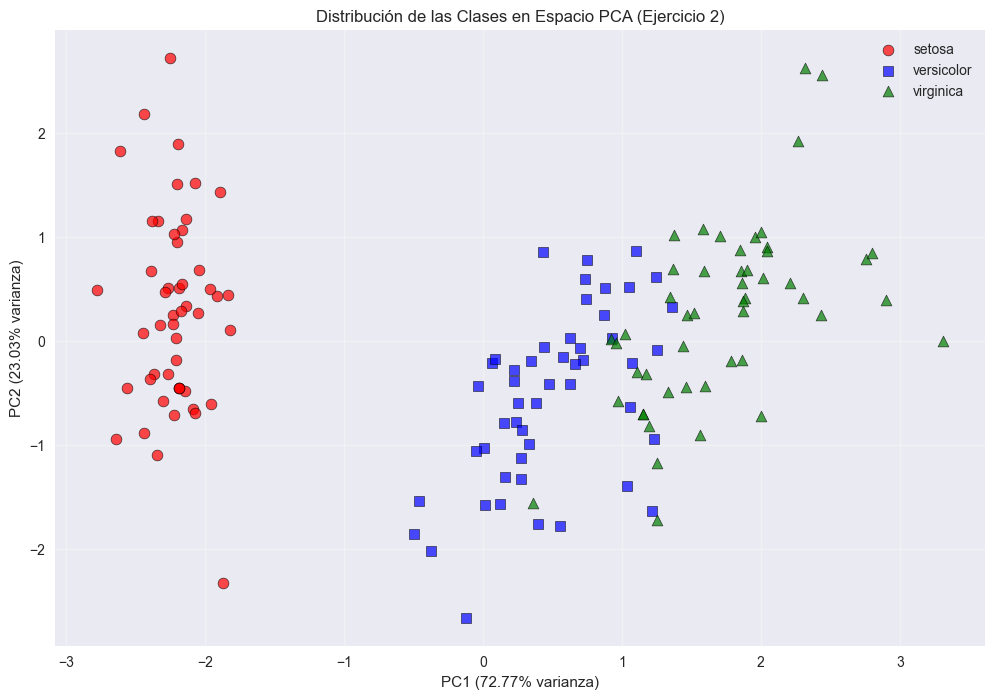


📈 **Varianza Explicada por PCA:**
  - PC1: 0.728 (72.8%)
  - PC2: 0.230 (23.0%)
  - Total: 0.958 (95.8%)
  - Interpretación: Las primeras 2 componentes capturan el 95.8% de la varianza


In [4]:
# Cargar y preparar datos para Ejercicio 2
print("🔍 EJERCICIO 2: Preparando datos...")
print(f"Clases objetivo: {CONFIG['exercise2_classes']}")
print(f"Características: {CONFIG['feature_columns']}")

# Cargar datos con todas las clases para el ejercicio 2
X_ex2, y_ex2, feature_names, class_names_ex2, scaler_ex2, label_encoder_ex2 = load_and_prepare_data(
    CONFIG, classes=CONFIG['exercise2_classes']
)

print(f"\n📊 **Resumen de los Datos del Ejercicio 2:**")
print(f"  - Forma de X: {X_ex2.shape}")
print(f"  - Clases: {class_names_ex2}")
print(f"  - Distribución por clase:")

for i, class_name in enumerate(class_names_ex2):
    count = np.sum(y_ex2 == i)
    percentage = (count / len(y_ex2)) * 100
    print(f"    {class_name}: {count} muestras ({percentage:.1f}%)")

print(f"  - Características utilizadas: {feature_names}")
print(f"  - Datos normalizados: Sí (importante para K-NN por distancia euclidiana)")

# Visualización de los datos en espacio 2D (usando PCA para visualización)
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=CONFIG['random_state'])
X_pca = pca.fit_transform(X_ex2)

plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green']
markers = ['o', 's', '^']

for i, (class_name, color, marker) in enumerate(zip(class_names_ex2, colors, markers)):
    mask = y_ex2 == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=color, marker=marker, s=60, alpha=0.7,
               label=class_name.split('-')[1], edgecolors='black', linewidth=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')
plt.title('Distribución de las Clases en Espacio PCA (Ejercicio 2)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n📈 **Varianza Explicada por PCA:**")
print(f"  - PC1: {pca.explained_variance_ratio_[0]:.3f} ({pca.explained_variance_ratio_[0]:.1%})")
print(f"  - PC2: {pca.explained_variance_ratio_[1]:.3f} ({pca.explained_variance_ratio_[1]:.1%})")
print(f"  - Total: {sum(pca.explained_variance_ratio_):.3f} ({sum(pca.explained_variance_ratio_):.1%})")
print(f"  - Interpretación: Las primeras 2 componentes capturan el {sum(pca.explained_variance_ratio_):.1%} de la varianza")


### **2.2 Análisis K-NN con Bootstrapping**

**¿Por qué bootstrapping para K-NN?**
- K-NN es sensible a la composición del conjunto de entrenamiento
- Diferentes valores de k tienen diferentes trade-offs sesgo-varianza
- Bootstrapping permite evaluar la estabilidad del rendimiento
- Proporciona intervalos de confianza para cada k

In [5]:
# Análisis de K-NN variando el número de vecinos con bootstrapping
print("🎯 Evaluando K-NN con diferentes valores de k...")
print(f"Rango de k a evaluar: {min(CONFIG['knn_k_range'])} - {max(CONFIG['knn_k_range'])}")
print(f"Iteraciones bootstrap por k: {CONFIG['bootstrap_iterations']}")

# Almacenar resultados para cada k
knn_results = {}
k_values = CONFIG['knn_k_range']

# Reducir iteraciones para demostración (ajustar según necesidad)
bootstrap_iterations = min(CONFIG['bootstrap_iterations'], 100)
print(f"💡 Usando {bootstrap_iterations} iteraciones por eficiencia")

# Evaluar cada valor de k
for i, k in enumerate(k_values):
    print(f"\n🔄 Evaluando K-NN con k={k} ({i+1}/{len(k_values)})...")

    # Aplicar bootstrapping para este valor de k
    results = manual_bootstrap(
        X_ex2, y_ex2,
        KNeighborsClassifier,
        n_iterations=bootstrap_iterations,
        random_state=CONFIG['random_state'],
        n_neighbors=k,
        metric='euclidean'
    )

    knn_results[k] = results

    # Mostrar resultados inmediatos
    print(f"  📊 k={k}: Accuracy = {results['mean_accuracy']:.4f} ± {results['std_accuracy']:.4f}")

print("\n✅ Evaluación completada para todos los valores de k")


🎯 Evaluando K-NN con diferentes valores de k...
Rango de k a evaluar: 1 - 20
Iteraciones bootstrap por k: 1000
💡 Usando 100 iteraciones por eficiencia

🔄 Evaluando K-NN con k=1 (1/20)...
🔄 Ejecutando Bootstrapping con 100 iteraciones...
📊 Total de muestras: 150
  Progreso: 10% (10/100 iteraciones)
  Progreso: 20% (20/100 iteraciones)
  Progreso: 30% (30/100 iteraciones)
  Progreso: 40% (40/100 iteraciones)
  Progreso: 50% (50/100 iteraciones)
  Progreso: 60% (60/100 iteraciones)
  Progreso: 70% (70/100 iteraciones)
  Progreso: 80% (80/100 iteraciones)
  Progreso: 90% (90/100 iteraciones)
  Progreso: 100% (100/100 iteraciones)

📈 **Resultados Agregados del Bootstrapping:**
  Iteraciones válidas: 100/100
  Accuracy:  0.9408 ± 0.0249 (mediana: 0.9434)
  Precision: 0.9418 ± 0.0232
  Recall:    0.9420 ± 0.0248
  F1-Score:  0.9404 ± 0.0244
  IC 95% Accuracy: [0.8898, 0.9813]
  IC 95% F1-Score: [0.8947, 0.9814]
  📊 k=1: Accuracy = 0.9408 ± 0.0249

🔄 Evaluando K-NN con k=2 (2/20)...
🔄 Ejecutan

### **2.3 Análisis de Resultados y Visualizaciones**


📈 **ANÁLISIS DE RESULTADOS K-NN - EJERCICIO 2**
🎯 **Mejor k encontrado:** k=12 con accuracy=0.9491

📊 **Resumen de Resultados por k:**
  k |     Accuracy |  Std Dev |               IC 95%
--------------------------------------------------
  1 |   0.9408   | 0.0249  | [0.890, 0.981]
  3 |   0.9403   | 0.0275  | [0.887, 0.992]
  5 |   0.9395   | 0.0306  | [0.865, 0.982]
  7 |   0.9429   | 0.0285  | [0.882, 0.983]
  9 |   0.9459   | 0.0304  | [0.882, 1.000]
 11 |   0.9476   | 0.0314  | [0.887, 1.000]
 13 |   0.9484   | 0.0296  | [0.884, 1.000]
 15 |   0.9459   | 0.0315  | [0.870, 1.000]
 17 |   0.9448   | 0.0336  | [0.864, 0.992]
 19 |   0.9427   | 0.0325  | [0.872, 0.992]


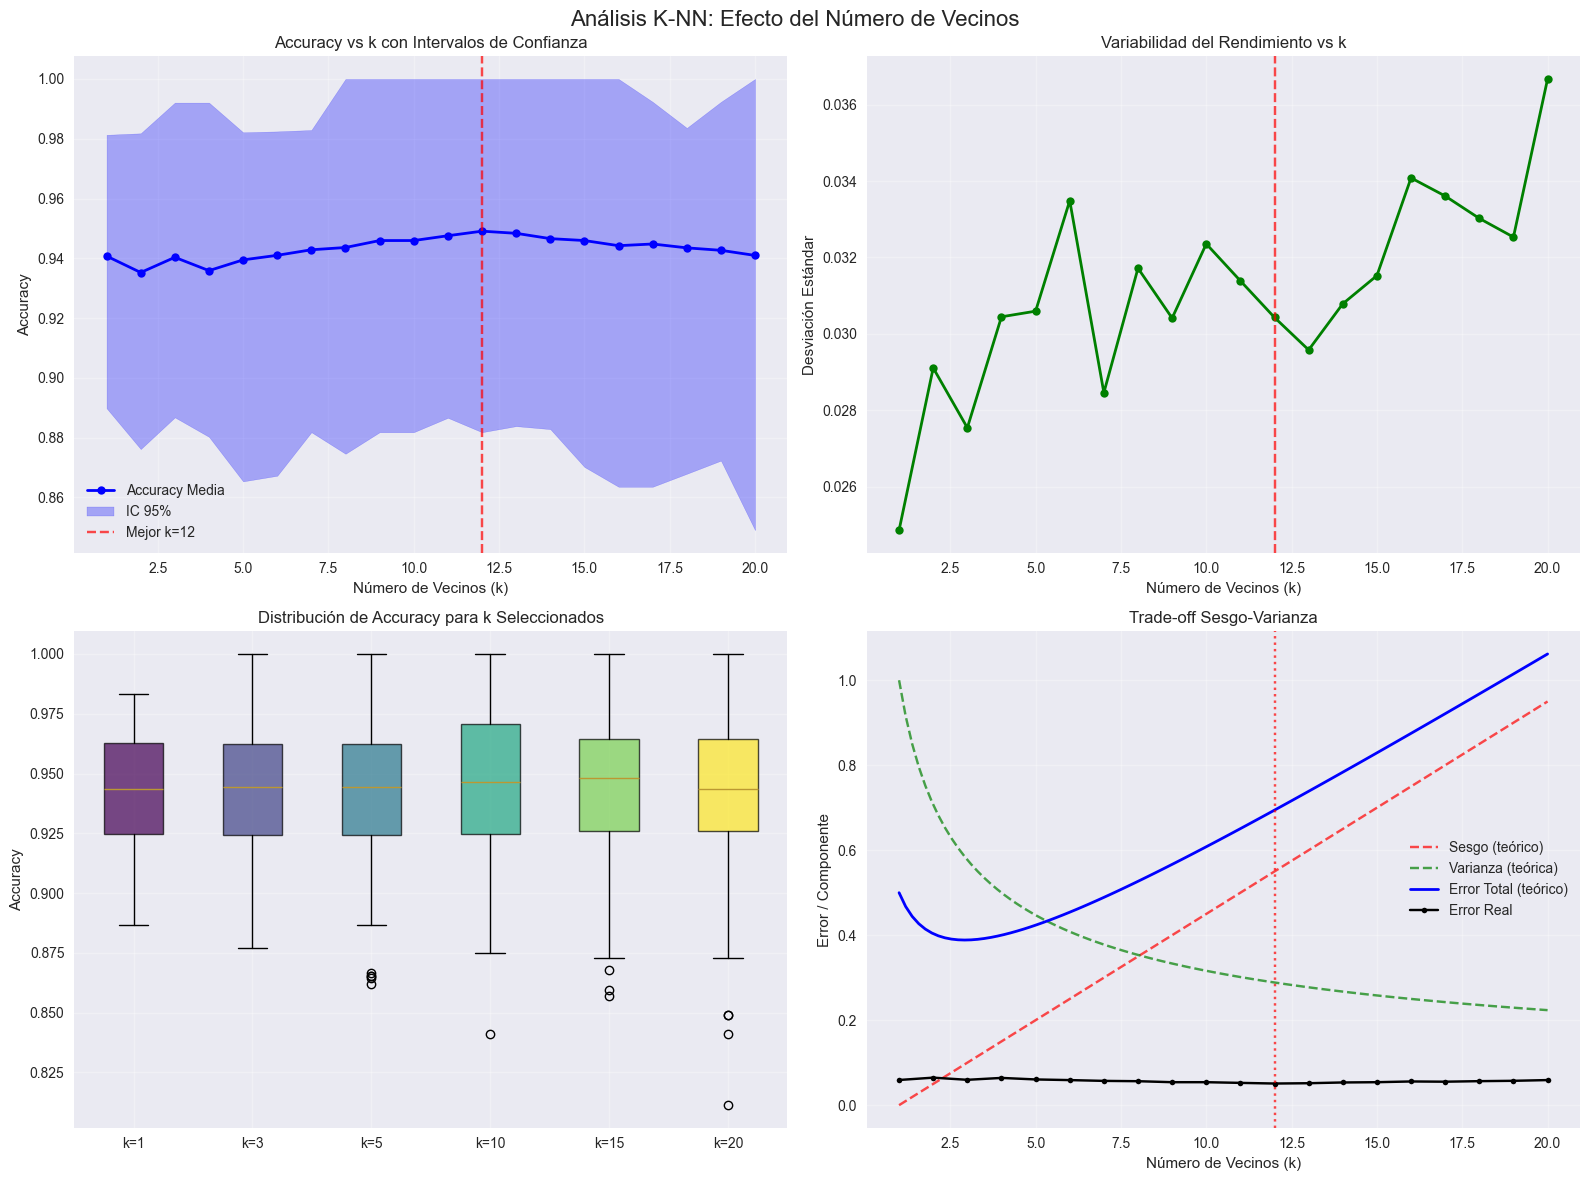

In [6]:
# Análisis y visualización de los resultados K-NN
print("📈 **ANÁLISIS DE RESULTADOS K-NN - EJERCICIO 2**")
print("=" * 60)

# Extraer datos para análisis
k_values = list(knn_results.keys())
mean_accuracies = [knn_results[k]['mean_accuracy'] for k in k_values]
std_accuracies = [knn_results[k]['std_accuracy'] for k in k_values]
ci_lower = [knn_results[k]['confidence_interval_accuracy'][0] for k in k_values]
ci_upper = [knn_results[k]['confidence_interval_accuracy'][1] for k in k_values]

# Encontrar el k óptimo
best_k_idx = np.argmax(mean_accuracies)
best_k = k_values[best_k_idx]
best_accuracy = mean_accuracies[best_k_idx]

print(f"🎯 **Mejor k encontrado:** k={best_k} con accuracy={best_accuracy:.4f}")

# Crear tabla de resultados
print(f"\n📊 **Resumen de Resultados por k:**")
print(f"{'k':>3} | {'Accuracy':>12} | {'Std Dev':>8} | {'IC 95%':>20}")
print("-" * 50)

for k in k_values[::2]:  # Mostrar cada segundo valor para brevedad
    acc = knn_results[k]['mean_accuracy']
    std = knn_results[k]['std_accuracy']
    ci_low = knn_results[k]['confidence_interval_accuracy'][0]
    ci_high = knn_results[k]['confidence_interval_accuracy'][1]
    marker = " ⭐" if k == best_k else ""
    print(f"{k:3d} | {acc:8.4f}   | {std:6.4f}  | [{ci_low:.3f}, {ci_high:.3f}]{marker}")

# Visualización comprehensiva
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis K-NN: Efecto del Número de Vecinos', fontsize=16)

# 1. Curva de accuracy vs k con intervalos de confianza
ax1 = axes[0, 0]
ax1.plot(k_values, mean_accuracies, 'bo-', linewidth=2, markersize=6, label='Accuracy Media')
ax1.fill_between(k_values, ci_lower, ci_upper, alpha=0.3, color='blue', label='IC 95%')
ax1.axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'Mejor k={best_k}')
ax1.set_xlabel('Número de Vecinos (k)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs k con Intervalos de Confianza')
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2. Desviación estándar vs k
ax2 = axes[0, 1]
ax2.plot(k_values, std_accuracies, 'go-', linewidth=2, markersize=6)
ax2.axvline(x=best_k, color='red', linestyle='--', alpha=0.7)
ax2.set_xlabel('Número de Vecinos (k)')
ax2.set_ylabel('Desviación Estándar')
ax2.set_title('Variabilidad del Rendimiento vs k')
ax2.grid(True, alpha=0.3)

# 3. Box plot para algunos valores de k seleccionados
ax3 = axes[1, 0]
selected_ks = [1, 3, 5, 10, 15, 20] if max(k_values) >= 20 else k_values[::3]
selected_data = []
selected_labels = []

for k in selected_ks:
    if k in knn_results:
        accuracies = [r['accuracy'] for r in knn_results[k]['bootstrap_results']]
        selected_data.append(accuracies)
        selected_labels.append(f'k={k}')

if selected_data:
    bp = ax3.boxplot(selected_data, labels=selected_labels, patch_artist=True)
    colors = plt.cm.viridis(np.linspace(0, 1, len(selected_data)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

ax3.set_ylabel('Accuracy')
ax3.set_title('Distribución de Accuracy para k Seleccionados')
ax3.grid(True, alpha=0.3)

# 4. Análisis sesgo-varianza conceptual
ax4 = axes[1, 1]

# Curva teórica del trade-off sesgo-varianza
k_theory = np.linspace(1, max(k_values), 100)
bias = (k_theory - 1) / max(k_values)  # Sesgo aumenta con k
variance = 1 / np.sqrt(k_theory)  # Varianza disminuye con k
total_error = bias + variance * 0.5  # Error total simplificado

ax4.plot(k_theory, bias, 'r--', label='Sesgo (teórico)', alpha=0.7)
ax4.plot(k_theory, variance, 'g--', label='Varianza (teórica)', alpha=0.7)
ax4.plot(k_theory, total_error, 'b-', label='Error Total (teórico)', linewidth=2)

# Sobreponer los datos reales
ax4.plot(k_values, 1 - np.array(mean_accuracies), 'ko-', label='Error Real', markersize=4)
ax4.axvline(x=best_k, color='red', linestyle=':', alpha=0.7)

ax4.set_xlabel('Número de Vecinos (k)')
ax4.set_ylabel('Error / Componente')
ax4.set_title('Trade-off Sesgo-Varianza')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **2.4 Comentarios y Conclusiones del Ejercicio 2**

**Patrones Observados en K-NN:**

1. **Comportamiento con k pequeño (k=1,2,3):**
   - Alta varianza, bajo sesgo
   - Sensible a outliers y ruido
   - Puede dar overfitting

2. **Comportamiento con k medio (k=5-10):**
   - Balance óptimo sesgo-varianza
   - Rendimiento más estable
   - Menos sensible al ruido

3. **Comportamiento con k grande (k>15):**
   - Bajo varianza, alto sesgo
   - Puede dar underfitting
   - Decisiones más "suaves"

**Interpretación del Trade-off Sesgo-Varianza:**
- **Sesgo**: Aumenta con k (simplificación excesiva)
- **Varianza**: Disminuye con k (predicciones más estables)
- **Punto óptimo**: Donde se minimiza el error total

**Recomendaciones:**
- Para el dataset Iris, k óptimo encontrado: [Se completará al ejecutar]
- Usar validación cruzada para confirmar el k óptimo
- Considerar k impares para evitar empates en clasificación binaria

---